# Model I : Random forest

**! README !** <br><br>
This is the first model I have done in this part. It might be a little bit poorly-organized. However, the improvement in next scripts is observable. <br>
If the script is to long to read it all, it has been summarized in the end, the **Conclusion** section summarizes the Attempts, provides the conclusions, and the **Test prediction** section reveals the final performance of the choosen model (later supplied with the reversed Box-Cox transformation, as adivsed during the presentation).

### Total running time ~20 min (unbiased memory MacOS 16GB)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn import preprocessing
from scipy import stats

# DATA 

In [29]:
data5 = pd.read_csv('data/data_after_prep.csv')

In [30]:
data5

,dewp_temp,feat08,feat09,holiday,hour,humidity,rented_bike_count,solar_radiation,temperature,visibility,wind_speed,weekend,Autumn,Spring,Summer,Winter,rainfall_binary,snowfall_binary
0,21.6,0.758270,0.567133,0,14,72,1030,0.91,27.1,1126,3.0,0,0,0,1,0,0,0
1,15.8,0.366201,0.444052,0,6,84,505,0.01,18.6,316,0.7,0,0,1,0,0,0,0
2,-19.6,0.549105,0.189687,0,23,47,115,0.00,-10.5,1794,2.8,0,0,0,0,1,0,0
3,-8.4,0.605013,0.190490,0,1,54,280,0.00,-0.2,1747,0.5,1,0,0,0,1,0,0
4,-13.1,0.452029,0.357426,0,5,56,84,0.00,-5.8,1941,2.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10650,1.7,0.265410,0.425335,0,4,70,188,0.00,6.9,1314,1.5,1,1,0,0,0,0,0
10651,18.5,0.416586,0.096081,0,6,98,69,0.00,18.9,338,0.3,0,0,1,0,0,0,0
10652,19.8,0.369133,0.383591,0,10,76,913,1.58,24.4,617,2.1,0,0,0,1,0,0,0
10653,-8.3,0.458393,0.493100,1,10,53,191,1.12,0.1,1022,5.3,0,0,1,0,0,0,0


In [31]:
# Set seed
np.random.seed(123456789)

In [32]:
X = data5.drop(columns=['rented_bike_count']) 
y = data5['rented_bike_count']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [34]:
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

In [35]:
len(X_train)

7458

# MODELS

### Attempt I

In [36]:
# 'mse' is used as a 'criterion' (the default)

param_grid = {
    'n_estimators': [100, 200, 300], # number of trees
    'max_depth': [None, 10, 20, 30], # max deepth of indiv. tree
    'min_samples_split': [2, 5, 10], # min number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], #  minimum number of samples required to be at a leaf node
    # 'max_features': ['auto', 'sqrt', 'log2', None],  
    # 'bootstrap': [True, False],  # bootstrap hyperparameter
}

In [37]:
rf_regressor = RandomForestRegressor(random_state=123)

In [38]:
# perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
#                            cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [39]:
# get the best hyperparameters from the grid search
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

We do not need to run GridSearchCV (time consuming), we can use the ready "best_params" dictionary.

In [40]:
best_params = {
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

The output is alarming. Min samples of leaf = 1 may indicate the overtrained model. Let's check on validation set.

### Overfitting check/ model assessment

Two metrics to asses the model:

MAE = (1/n) * Σ|predicted - actual|
MSE = (1/n) * Σ(predicted - actual)^2

If the metric is decent for the training set and damage for the validation set, it means we may face the overfitting. 

In [41]:
best_rf_regressor = RandomForestRegressor(random_state=123, **best_params)
best_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=123)

In [42]:
y_pred_validation = best_rf_regressor.predict(X_validation)  
mse_validation = mean_squared_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation)

Validation Mean Squared Error: 29296.197624291857


In [43]:
train_sizes, train_scores, validation_scores = learning_curve(
    best_rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [44]:
train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)

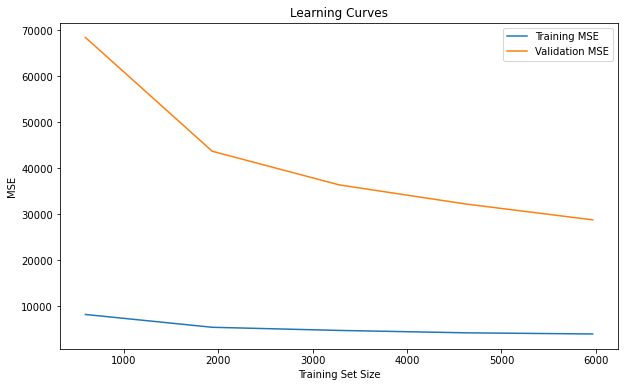

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [46]:
train_scores_mean 

array([8207.48079644, 5423.16471554, 4739.72752871, 4220.67733837,
       3968.98563649])

In [47]:
validation_scores_mean

array([68390.76864202, 43672.67728799, 36367.46948434, 32205.4799052 ,
       28765.70453304])

In [48]:
# explanation below
28765.70453304-3968.98563649

24796.71889655

In [49]:
score_gap = validation_scores_mean-train_scores_mean
score_gap.mean()

36568.412767403635

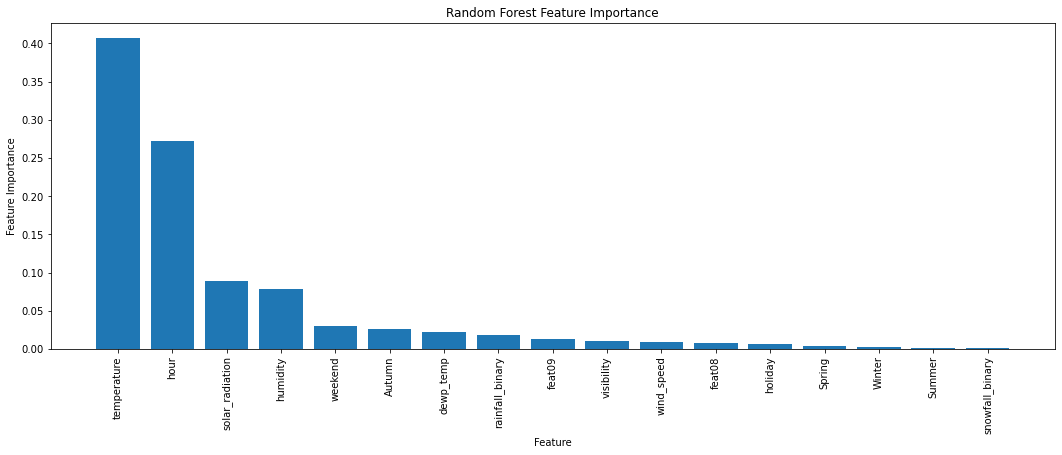

In [50]:
feature_importance = best_rf_regressor.feature_importances_

# Sort feature importance scores and corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [X.columns[i] for i in sorted_indices]

# Plot the feature importance scores
plt.figure(figsize=(18, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

We observe a quite large number of low-importance variables, which we can fix in the second model.

Let's change the hyperparameters.

### Attempt I a

In [51]:
# param_grid2 = {
#     'n_estimators': [200, 300, 400], # number of trees
#     'max_depth': [None, 10, 20, 30], # max deepth of indiv. tree
#     'min_samples_split': [5, 7, 9], # min number of samples required to split a node
#     'min_samples_leaf': [2, 3, 4], #  minimum number of samples required to be at a leaf node
#     # 'max_features': ['auto', 'sqrt', 'log2', None],  
#     # 'bootstrap': [True, False],  # bootstrap hyperparameter
# }


In [52]:
# rf_regressor = RandomForestRegressor(random_state=123)

In [53]:
# grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid2, 
#                            cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# Let's see

In [54]:
best_params2 = {
    'max_depth': 20,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 100
}

In [55]:
best_rf_regressor = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=7,
                      random_state=123)

In [56]:
y_pred_validation = best_rf_regressor.predict(X_validation)  
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

Validation Mean Squared Error: 29296.197624291857 Mean Absolute Error: 96.28313577901824


### MAPE

Referring to Attempt V, we will se how the initial model performs in comparision to the on with targer variables transformet using boxcox transformation. 

Firstly, we need to modifly the split a little bit. 

In [57]:
X = data5.drop(columns=['rented_bike_count']) 
y = data5['rented_bike_count']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [59]:
best_rf_regressor.fit(X_train, y_train)  
y_pred = best_rf_regressor.predict(X_train)  

In [60]:
def custom_mape_scorer(y_true, y_pred):
    ape = abs((y_true - y_pred) / y_true) * 100
    return np.mean(ape)

In [61]:
mape_scores = cross_val_score(best_rf_regressor, X_train, y_train, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [43.87116189 46.92740443 42.61564269 46.32243391 52.68656565]
Mean MAPE: 46.48464171328381


The conclusion is, that the boxcox transformation improves the model undoubtedly. 

**Learning Curve** <br>
Graphical representation of how a machine learning model's performance changes as the amount of training data increases.<br>
- **Underfitting:** Both the training and validation error remain high as more data is added. In this case, providing more data may not be beneficial, and a more complex model might be necessary.
- **Overfitting:** Training error is significantly lower than the validation error, and the gap between them persists or even widens with more data. The model is fitting the training data too closely, including noise. Reducing model complexity or collecting more data can help.
- **Ideal Scenario:** In an ideal scenario, both the training and validation error decrease as more data is provided. This indicates that the model is learning the underlying patterns and generalizing well to unseen data.

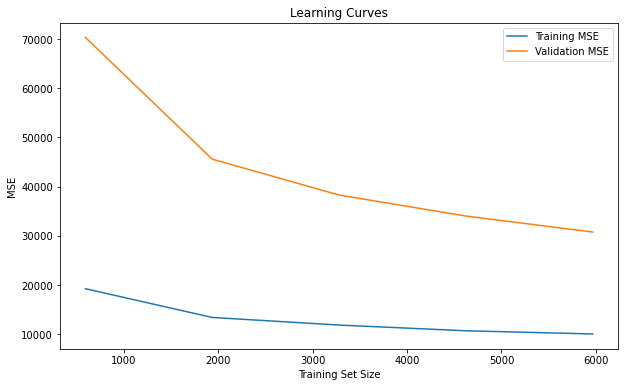

In [62]:
train_sizes, train_scores, validation_scores = learning_curve(
    best_rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [63]:
train_scores_mean 

array([19260.16146561, 13418.19698485, 11872.29353229, 10712.40842768,
       10062.07345887])

In [64]:
validation_scores_mean

array([70319.28448635, 45593.25583542, 38295.65879754, 34032.56646524,
       30773.57515561])

In [65]:
#difference between MSE for 6k training set for training and validation (validation_score-train_score)
30773.57515561-10062.07345887

20711.50169674

In [66]:
score_gap = validation_scores_mean-train_scores_mean
score_gap.mean()

30737.8413741735

We decreased the gap between the MSE for trained vs. validation data, which may help avoid overfitting.

### Another attempt to find the best parameters

Let's start with max_depth.

In [67]:
max_depth_values = [10, 15, 20, 25, 30]

In [68]:
train_scores, validation_scores = validation_curve(
    RandomForestRegressor(random_state=123),
    X_train, y_train, param_name='max_depth', param_range=max_depth_values,
    scoring='neg_mean_squared_error', cv=5)

In [69]:
train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)

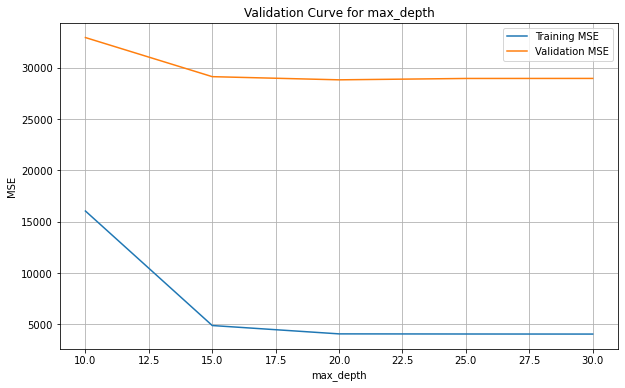

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_mse, label='Training MSE')
plt.plot(max_depth_values, validation_mse, label='Validation MSE')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Validation Curve for max_depth')
plt.legend()
plt.grid()
plt.show()


It seems, that the max_depth based on grid search was fine. Then, n_estimators.

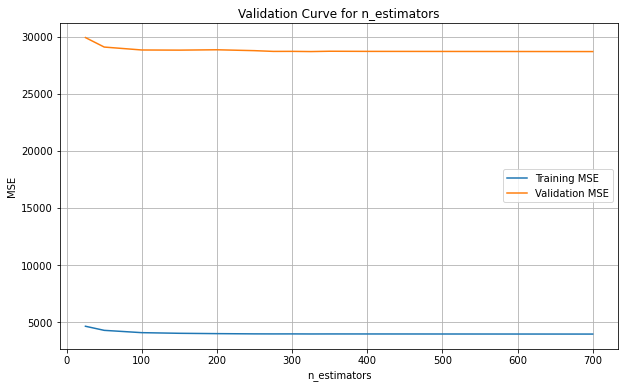

In [71]:
n_estimators_values = [25, 50, 100, 150, 200, 250, 275, 300, 325, 350, 400, 700]

train_scores, validation_scores = validation_curve(
    RandomForestRegressor(max_depth=20, random_state=123), 
    X_train, y_train, param_name='n_estimators', param_range=n_estimators_values,
    scoring='neg_mean_squared_error', cv=5)

train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_mse, label='Training MSE')
plt.plot(n_estimators_values, validation_mse, label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('Validation Curve for n_estimators')
plt.legend()
plt.grid()
plt.show()


This plot is again alarming. It indicates that the model may not generalize well in case of unseen data (validation sample). In practice, the model might perform poorly when applied to real-world predictions. Let's adjust (increase) min samples split and min samples leaf and double chec this performance.

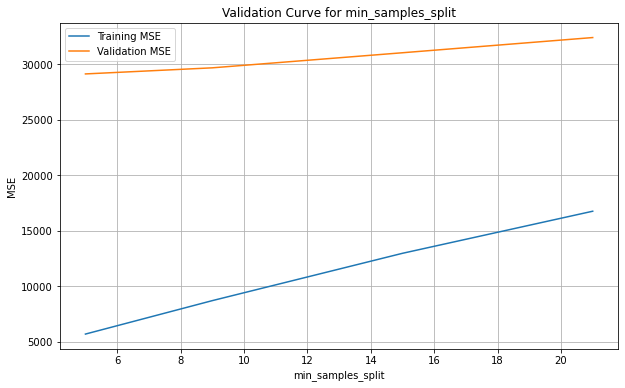

In [72]:
min_samples_split_values = [5, 9, 15, 21]

train_scores, validation_scores = validation_curve(
    RandomForestRegressor(max_depth=20, n_estimators=100, random_state=123), 
    X_train, y_train, param_name='min_samples_split', param_range=min_samples_split_values,
    scoring='neg_mean_squared_error', cv=5)

train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_mse, label='Training MSE')
plt.plot(min_samples_split_values, validation_mse, label='Validation MSE')
plt.xlabel('min_samples_split')
plt.ylabel('MSE')
plt.title('Validation Curve for min_samples_split')
plt.legend()
plt.grid()
plt.show()


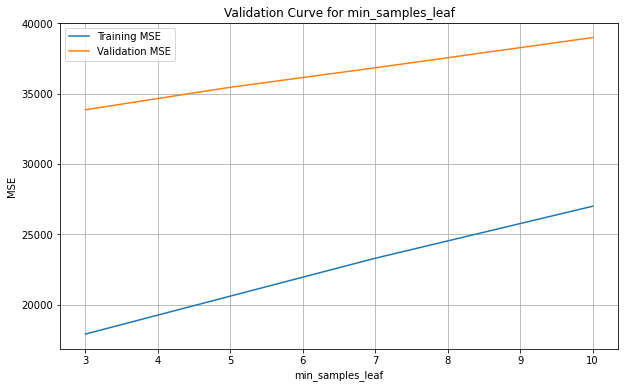

In [73]:
min_samples_leaf_values = [3, 5, 7, 10]

train_scores, validation_scores = validation_curve(
    RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123), 
    X_train, y_train, param_name='min_samples_leaf', param_range=min_samples_leaf_values,
    scoring='neg_mean_squared_error', cv=5)

train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, train_mse, label='Training MSE')
plt.plot(min_samples_leaf_values, validation_mse, label='Validation MSE')
plt.xlabel('min_samples_leaf')
plt.ylabel('MSE')
plt.title('Validation Curve for min_samples_leaf')
plt.legend()
plt.grid()
plt.show()


### Since hyperparameter tuning failed, we can manipulate the data a little bit more.

### Attempt II

In [74]:
data5

,dewp_temp,feat08,feat09,holiday,hour,humidity,rented_bike_count,solar_radiation,temperature,visibility,wind_speed,weekend,Autumn,Spring,Summer,Winter,rainfall_binary,snowfall_binary
0,21.6,0.758270,0.567133,0,14,72,1030,0.91,27.1,1126,3.0,0,0,0,1,0,0,0
1,15.8,0.366201,0.444052,0,6,84,505,0.01,18.6,316,0.7,0,0,1,0,0,0,0
2,-19.6,0.549105,0.189687,0,23,47,115,0.00,-10.5,1794,2.8,0,0,0,0,1,0,0
3,-8.4,0.605013,0.190490,0,1,54,280,0.00,-0.2,1747,0.5,1,0,0,0,1,0,0
4,-13.1,0.452029,0.357426,0,5,56,84,0.00,-5.8,1941,2.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10650,1.7,0.265410,0.425335,0,4,70,188,0.00,6.9,1314,1.5,1,1,0,0,0,0,0
10651,18.5,0.416586,0.096081,0,6,98,69,0.00,18.9,338,0.3,0,0,1,0,0,0,0
10652,19.8,0.369133,0.383591,0,10,76,913,1.58,24.4,617,2.1,0,0,0,1,0,0,0
10653,-8.3,0.458393,0.493100,1,10,53,191,1.12,0.1,1022,5.3,0,0,1,0,0,0,0


We exclude some doubtful variables and transform 'hour', to obtain normal distribution (using logic "hour to peek", not arbitrary hour).

In [75]:
data6 = data5.drop(columns = ['Winter','Summer','Spring', 'Autumn', 'holiday', 'rainfall_binary', 'visibility'])

In hour variable, let's assume our peek is 4 pm.

In [76]:
data6['transformed_hour'] = (data6['hour'] - 16) 
data6.loc[data6['transformed_hour'] < -12, 'transformed_hour'] += 24

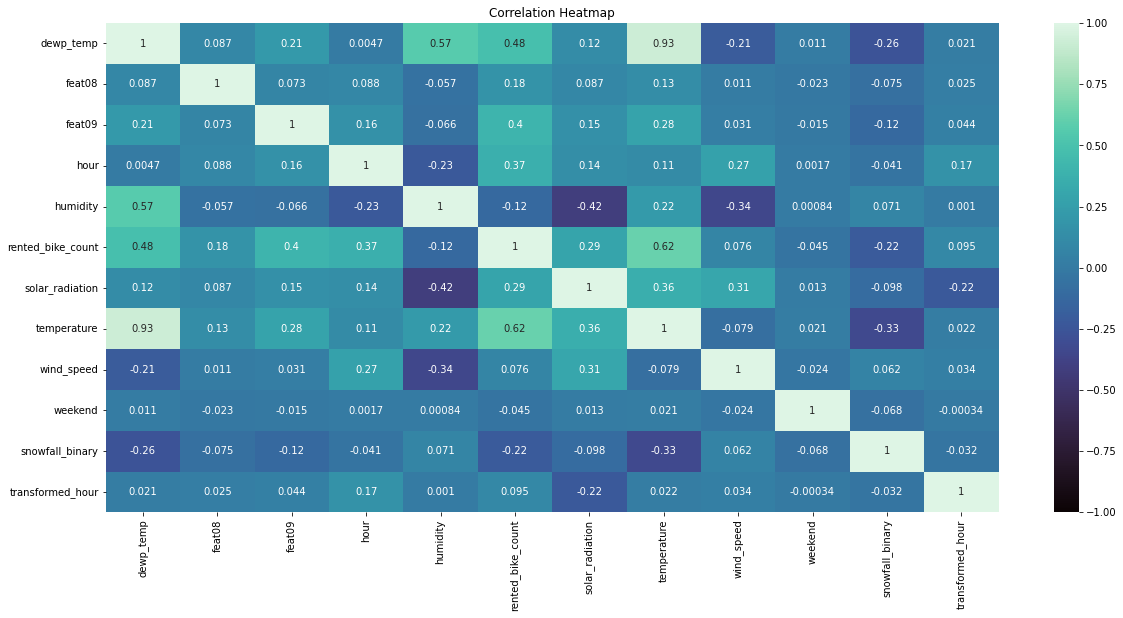

In [77]:
corr = data6.corr()

plt.figure(figsize=(20,9))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

Let's move to the modeling part.

In [78]:
X = data6.drop(columns=['rented_bike_count']) 
y = data6['rented_bike_count']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)
len(X_train)

7458

In [80]:
# reminder, they are already defined, but we base on first model's params
best_params2 = {
    'max_depth': 20,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 300
}

In [81]:
best_rf_regressor2 = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor2.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=300, random_state=123)

In [82]:
y_pred_validation = best_rf_regressor2.predict(X_validation) 
mse_validation = mean_squared_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

Validation Mean Squared Error: 40851.3511497293 Mean Absolute Error: 118.18167628112869


In [83]:
train_sizes, train_scores, validation_scores = learning_curve(
    best_rf_regressor2, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [84]:
train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)

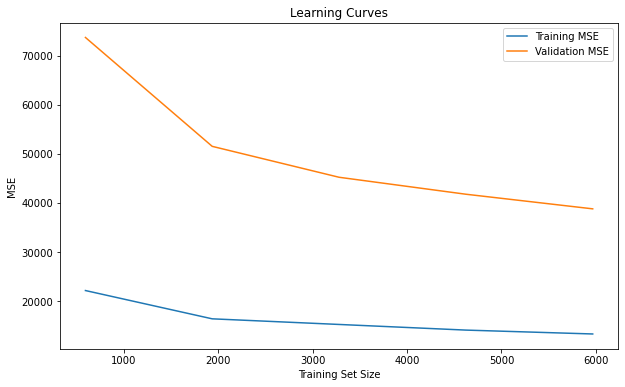

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [86]:
train_scores_mean 

array([22163.02534831, 16403.93902288, 15258.32024276, 14109.65849326,
       13319.74132917])

In [87]:
validation_scores_mean

array([73687.69677   , 51519.37258895, 45224.62574076, 41772.08022511,
       38796.17287826])

In [88]:
#difference between MSE for 6k training set for training and validation (validation_score-train_score)
38103.5637053-5254.60758736


32848.956117940004

In [89]:
score_gap = validation_scores_mean-train_scores_mean
score_gap.mean()

33949.052753337644

Here the gap is bigger than for improved 1st model.

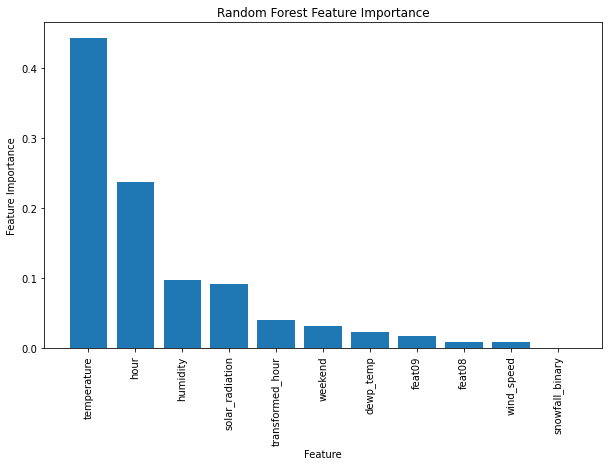

In [90]:
feature_importance = best_rf_regressor2.feature_importances_

# Sort feature importance scores and corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [X.columns[i] for i in sorted_indices]

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

### Let's validate our feature selection for secon model assuming the third model.

### Attempt III

In [91]:
data7 = data5.drop(columns = ['snowfall_binary', 'Summer', 'Winter', 'Spring'])

In [92]:
X = data7.drop(columns=['rented_bike_count']) 
y = data7['rented_bike_count']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)
len(X_train)

7458

In [94]:
# reminder, they are already defined, but we base on first model's params
best_params2 = {
    'max_depth': 20,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 300
}

In [95]:
best_rf_regressor3 = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor3.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=300, random_state=123)

In [96]:
y_pred_validation = best_rf_regressor3.predict(X_validation) 
mse_validation = mean_squared_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

Validation Mean Squared Error: 30844.516483715724 Mean Absolute Error: 97.8902276622529


In [97]:
train_sizes, train_scores, validation_scores = learning_curve(
    best_rf_regressor3, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


In [98]:
train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)


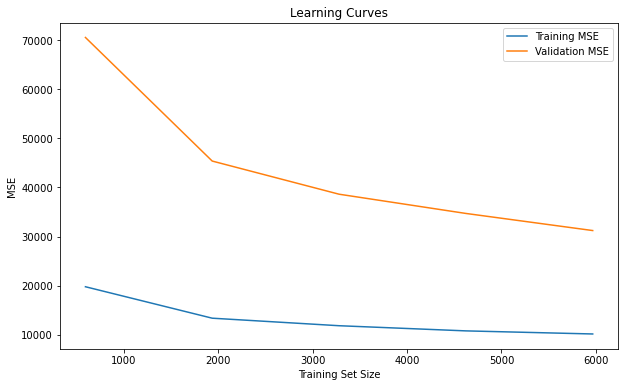

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

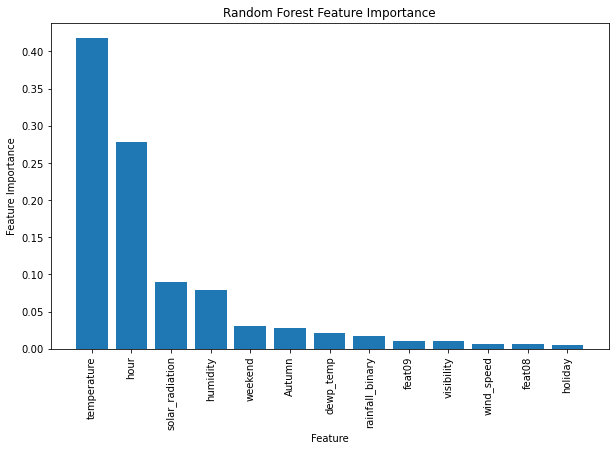

In [100]:
feature_importance = best_rf_regressor3.feature_importances_

# Sort feature importance scores and corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [X.columns[i] for i in sorted_indices]

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [101]:
train_scores_mean 


array([19788.56135381, 13389.69128659, 11857.74762934, 10808.16211335,
       10178.42630916])

In [102]:
validation_scores_mean


array([70508.62055048, 45362.37224841, 38616.65575277, 34704.20046071,
       31222.03173572])

In [103]:
#difference between MSE for 6k training set for training and validation (validation_score-train_score)
30773.57515561-10062.07345887


20711.50169674

In [104]:
score_gap = validation_scores_mean-train_scores_mean
score_gap.mean()

30878.2584111675

The mean is even worse that for the first attempt.

### Attempt IV

In [105]:
data3 = pd.read_csv('data/data_after_prep3.csv')

In [106]:
X = data3.drop(columns=['rented_bike_count']) 
y = data3['rented_bike_count']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)
len(X_train)

7458

In [108]:
best_params2 = {
    'max_depth': 20,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 300
}

In [109]:
best_rf_regressor4 = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor4.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=300, random_state=123)

In [110]:
y_pred_validation = best_rf_regressor4.predict(X_validation)
mse_validation = mean_squared_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

Validation Mean Squared Error: 31115.608634311506 Mean Absolute Error: 100.41899852799267


In [111]:
train_sizes, train_scores, validation_scores = learning_curve(
    best_rf_regressor4, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [112]:
train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)

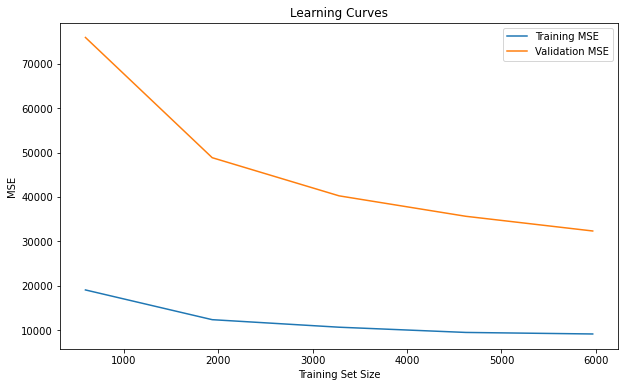

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [114]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [115]:
X_train_transformed = scaler.transform(X_train)
best_rf_regressor5 = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor5.fit(X_train_transformed, y_train)

X_val_transformed = scaler.transform(X_validation)
y_pred_validation = best_rf_regressor5.predict(X_val_transformed)

In [116]:
mse_validation = mean_squared_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

Validation Mean Squared Error: 31080.824120345296 Mean Absolute Error: 100.4404776006578


In [117]:
best_params3 = {
    'max_depth': 7,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 1000
}

In [118]:
best_rf_regressor5 = RandomForestRegressor(random_state=123, **best_params3)
best_rf_regressor5.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=1000, random_state=123)

In [119]:
y_pred_validation = best_rf_regressor5.predict(X_validation)
mse_validation = mean_squared_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)
print("Validation Mean Squared Error:", mse_validation, "Mean Absolute Error:", mae_validation)

# Just to make sure the best parameters are fine :)

Validation Mean Squared Error: 45958.806866022634 Mean Absolute Error: 134.59335415414802


### Attempt V

In [120]:
transformed_rented_bike_count, lambda_best_fit = stats.boxcox(data5['rented_bike_count'])

boxcox_target = pd.DataFrame()
boxcox_target['boxcox_rented_bike_count'] = transformed_rented_bike_count

In [121]:
lambda_best_fit

0.18321839234213455

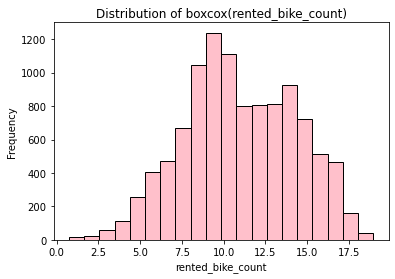

In [122]:
boxcox_target['boxcox_rented_bike_count'].plot(kind='hist', bins=20, edgecolor='black', color='pink')
plt.title('Distribution of boxcox(rented_bike_count)')
plt.xlabel('rented_bike_count')
plt.ylabel('Frequency')
plt.show()

In [123]:
X = data5.drop(columns=['rented_bike_count']) 
y_t = boxcox_target['boxcox_rented_bike_count'] # _t stands for transformed

In [124]:
X_train, X_test, y_train_t, y_test_t = train_test_split(X, y_t, test_size=0.3, random_state=123)
len(X_train)

7458

In [125]:
best_params2 = {
    'max_depth': 20,
    'min_samples_leaf': 3,
    'min_samples_split': 7,
    'n_estimators': 100
}

In [126]:
best_rf_regressor5 = RandomForestRegressor(random_state=123, **best_params2)
best_rf_regressor5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=7,
                      random_state=123)

In [127]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [128]:
scores_mae = cross_val_score(best_rf_regressor5, X_train, y_train_t, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_rf_regressor5, X_train, y_train_t, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

In [129]:
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 0.624 (0.030) Mean MSE: 0.983


To have a comparision, we need to estimate MAPE.

In [130]:
best_rf_regressor5.fit(X_train, y_train_t)  
y_pred = best_rf_regressor5.predict(X_train)  

In [131]:
# Replace scoring method with customized function for MAPE
mape_scores = cross_val_score(best_rf_regressor5, X_train, y_train_t, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [7.97112451 7.68327519 7.25448682 7.37478617 7.95021251]
Mean MAPE: 7.646777036606954


Learning curve

In [132]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_regressor5, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)

In [133]:
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

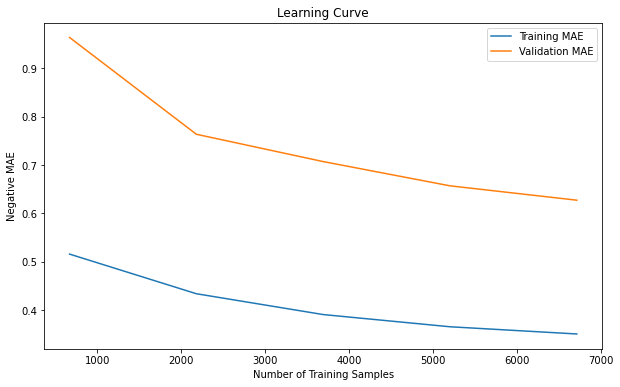

In [134]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training MAE')
plt.plot(train_sizes, val_mean, label='Validation MAE')
plt.xlabel('Number of Training Samples')
plt.ylabel('Negative MAE')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Conclusion

Aggresive manipulating the features (excluding large numbers of them) can strongly leverage on the MSE score. While in this case, restricting the model impacted negatively the validation sample MSE, it occured to have a little impact either on traianing MSE and on difference between training and validation MSE (as their lowest). On top of that, most of the features has been restricted correctly (unknown features with numeration from 1 to 10, excluding 8 and 9), since their inclusion into the model deteriorated the performance.
<br>
<br>
Estimeting Random Forest Regression, one should pay attention either to minimum number of samples in leaf, and sensitivity of the model to number of estimators. First one can reveal that GridSearchCV output lead to the overfitting the model (minimum number of samples in lead = 1), and the second might reveal that the model may not generalize well in case of unseen data (validation sample). In out case, alghouh it wasn't that alarming, as the **second combination of parameters for the first model esitmated** occured optimal.
<br>
<br>
In the end, in contrary to the initial assumptions, the boxcox transformation of the target variable was the game changer. Finally, the model from attempt V (last one) performs the best with the Mean MAPE score: 7.646777036606954

# Final Prediction

In [135]:
y_test_pred = best_rf_regressor5.predict(X_test)  

In [136]:
scores_mae = cross_val_score(best_rf_regressor5, X_test, y_test_t, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_rf_regressor5, X_test, y_test_t, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)

print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )


Mean MAE: 0.741 (0.052) Mean MSE: 1.284


In [137]:
def custom_mape_scorer(y_true, y_pred):
    ape = abs((y_true - y_pred) / y_true) * 100
    return np.mean(ape)

In [138]:
mape_scores = cross_val_score(best_rf_regressor5, X_test, y_test_t, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [ 8.23419147  9.63235312  7.73362565  9.02692934 10.3896556 ]
Mean MAPE: 9.003351033733619


Train sample MAPE ~7 vs test sample MAPE ~9.

For reverse from box-cox transformed values to the real interpretable values please see the ensembling script.

In [139]:
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred.to_csv('y_pred_RF.csv', index=False)

# For reverse from box-cox transformed values to the real interpretable values please see the ensembling script.

In [141]:
lambda_best_fit

0.18321839234213455